In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import datetime as dt
%matplotlib inline

In [2]:
# FUNCTIONS YOU CAN USE:
#     analyses(filepath) spits out a nifty heatmap to let you check correlation between variables
#
#     regress(option, df) churns out a saucy graph of the linear regression for the variables you provided, where
#       option is 'snr_total' or 'tsnr', whichever you want to make the dependent variable of your model
#       df is the pandas DataFrame containing your data. To modify which variables you want in your model, you'll
#             have to directly modify the regress function

In [3]:
# NOTABLE FILENAMES
# ../data/extractions/p2_BOLD.csv                  - all dates for p2_BOLD
# ../data/extractions/p2Xs4X35mm_BOLD.csv          - all dates for p2Xs4X35mm_BOLD
# ../data/extractions/anat.csv                     - all possible dates for anatomical data

In [4]:
def filter(option, df):
    is_p2 = df['Filetype'] == "task-rest_acq-p2_bold.json"
    is_x = df['Filetype'] == "task-rest_acq-p2Xs4X35mm_bold.json"
    
    if option == 'x':
        return df[is_x]
    elif option == 'p2':
        return df[is_p2]

In [2]:
def analyses(filepath):
    files = pd.read_csv(filepath)
    
    # FIRST CHECK: CONVERSION SOFTWARE VERSIONS
    check = files.iloc[0, 7]
    valid = True
    
    for i in files.index:
        if check != files.iloc[i, 7]:
            valid = False
            
    print("All Conversion Softwares are the same: " + str(valid))
    
    # SECOND CHECK: HEATMAP
    sns.heatmap(files.corr(), cmap=sns.diverging_palette(h_neg=240, h_pos=10, n=9, sep=1, center="dark"), center=0)

In [47]:
def regress(target_variable, model_df, plot=True):
    # creates a regression graph plotted against actual data from certain QA metrics
    #      target_variable: takes str value of either snr_total or tsnr to model against
    #      model_df       : takes pandas DataFrame with data to be used for predictive modeling
    #      plot           : boolean to turn the plotted graph on/off
    
    ########## target_variable MUST be snr_total OR tsnr
    if target_variable != 'snr_total' and target_variable != 'tsnr':
        return "Target variable must be snr_total or tsnr"
    
    elif type(model_df) is not pd.core.frame.DataFrame:
        return "DataFrame must be of type pandas.core.frame.DataFrame"
    
    
    
    ########## adding seasonal curves to the model
    n = len(model_df)
    date = str(model_df.iat[0,0])
    values = [np.sin(np.pi*i/(26)) for i in range(n)]
    values2 = [np.cos(np.pi*i/(26)) for i in range(n)]
    dates = [dt.datetime(int(date[:4]), int(date[4:6]), int(date[6:])) + dt.timedelta(days = i*7) for i in range(n)]

    sin = pd.DataFrame(values)
    sin.columns = ['seasonal (sin)']
    
    cos = pd.DataFrame(values2)
    cos.columns = ['seasonal (cos)']
    
    model_df = model_df.join(sin)
    model_df = model_df.join(cos)
    
    
    
    ########## Converting date to a format that can be parsed by statsmodels API
    model_df['Date'] = pd.to_datetime(model_df['Date'], format="%Y%m%d")
    model_df['Date2'] = model_df['Date'].map(pd.datetime.toordinal)
    
    
    
    ########## Assigning independent and dependent variables
    list = []
    
    for item in model_df.std().iteritems():
        if item[0] != 'Date' and item[0] != target_variable and item[1] != 0:
            list.append(item[0])

    X = model_df[list]
    X = sm.add_constant(X)
    y = model_df[target_variable]
    
    model_df = sm.add_constant(model_df)
    
    
    ########## modeling predictions
    model = sm.OLS(y, X).fit()
    predictions = model.predict(X)
    
    
    
    ################ CODE FOR TESTING INDIVIDUAL VARIABLE EFFECTS ####################
    significant_variables = [] 
    
    # get p-values
    for key, value in dict(model.pvalues).items():
        if value < 0.05 or key.lower() == 'const':
            # identify statistically insignificant variables in df
            significant_variables.append(key)
    
    
    
    ######## set statistically insignificant variables to 0, then predict
        
    iso_models = {}  # partial_fits = {}

    for variable in significant_variables:

        X2 = model_df.copy(True) # prepare for mods
        X2 = X2[list]
        X2 = sm.add_constant(X2)

        for col in X2:
            if col != variable:
                X2[col] = 0
        
        iso_models[str(variable)] = model.predict(X2)
        
    print("Statistically significant variables: " + str(significant_variables))
    
    ################ END CODE FOR TESTING INDIVIDUAL VARIABLE EFFECTS ####################
    
    if not plot:
        return model
    
    
    ######### converting the above predictions to a format that can be plotted
    
    plot_df = predictions.to_frame()       # new DataFrame containing only data needed for the plot
    plot_df.columns = ['full fit']
    plot_df = plot_df.join(model_df['Date'])
    plot_df = plot_df.join(model_df[target_variable])
    
    summation_df = None
    
    for key, value in iso_models.items():
        column = value.to_frame()
        column.columns = ['partial fit']

        if summation_df is None:
            summation_df = column          # used to add up the values
        else:
            summation_df = summation_df.add(column, axis=1)
    
    plot_df = pd.concat([plot_df, summation_df], axis=1)
    
    # plotting the graph
    plt.figure(figsize=(15, 6))

    ax = sns.lineplot(x="Date", y=target_variable, data=plot_df, color="#ff9933")
    ax_txrefamp = plt.twinx()
    sns.lineplot(x="Date", y="full fit", data=plot_df, color="r", ax=ax)
    sns.lineplot(x="Date", y="partial fit", data=plot_df, color="g", ax=ax_txrefamp)
    ax.legend(['actual', 'full fit'])
    ax_txrefamp.legend(['partial fit'])
    
    # giving additional data
    print(model.summary())
    
    if 'Shim1' and 'Shim2' and 'Shim3' and 'Shim4' and 'Shim5' and 'Shim6' and 'Shim7' and 'Shim8' in list:
        print("Shim F-test: ")
        print(model.f_test("Shim1 = Shim2 = Shim3 = Shim4 = Shim5 = Shim6 = Shim7 = Shim8 = 0"))
    
    if 'IOPD1' and 'IOPD2' and 'IOPD3' and 'IOPD4' and 'IOPD5' and 'IOPD6' in list:
        print("IOPD F-test: ")
        print(model.f_test("IOPD1 = IOPD2 = IOPD3 = IOPD4 = IOPD5 = IOPD6 = 0"))
    
    print("Seasonal F-test:")
    print(model.f_test("seasonal (sin) = seasonal (cos) = 0"))
    return model

All Conversion Softwares are the same: True


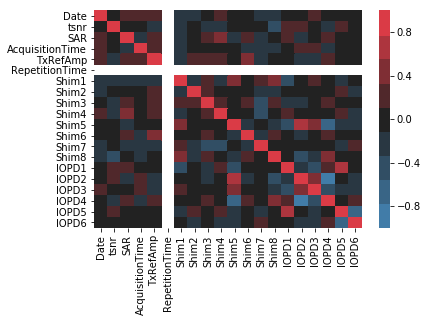

In [7]:
analyses('../data/extractions/p2_BOLD.csv')

All Conversion Softwares are the same: True


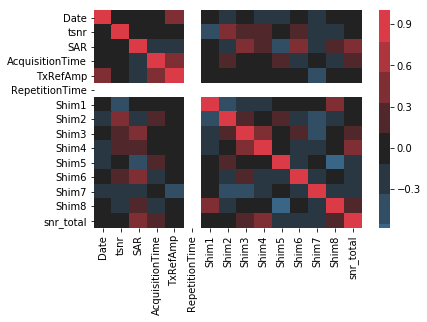

In [8]:
analyses('../data/extractions/p2_BOLD_snr.csv')

In [34]:
files = pd.read_csv('../data/extractions/p2_BOLD.csv')
df = pd.DataFrame(files,columns=['Date', 'tsnr', 'TxRefAmp', 'AcquisitionTime', 'SAR',
                                'RepetitionTime', 'Shim1', 'Shim2', 'Shim3', 'Shim4',
                                'Shim5', 'Shim6', 'Shim7', 'Shim8', 'IOPD1', 'IOPD2',
                                'IOPD3', 'IOPD4', 'IOPD5', 'IOPD6'])
# df_shim = pd.DataFrame(files,columns=['Date', 'tsnr', 'Shim1', 'Shim2', 'Shim3', 'Shim4',
#                                 'Shim5', 'Shim6', 'Shim7', 'Shim8'])
# df_iopd = pd.DataFrame(files,columns=['Date', 'tsnr', 'IOPD1', 'IOPD2',
#                                 'IOPD3', 'IOPD4', 'IOPD5', 'IOPD6'])
# df_tx = pd.DataFrame(files,columns=['Date', 'tsnr', 'TxRefAmp'])
# df_AT = pd.DataFrame(files,columns=['Date', 'tsnr', 'AcquisitionTime'])
# df_SAR = pd.DataFrame(files,columns=['Date', 'tsnr', 'SAR'])
# df_RT = pd.DataFrame(files,columns=['Date', 'tsnr', 'RepetitionTime'])

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


0    -97
1   -242
2   -260
3   -119
4    243
Name: Shim6, dtype: int64
             tsnr    TxRefAmp  AcquisitionTime        SAR  RepetitionTime  \
count   90.000000   90.000000        90.000000  90.000000            90.0   
mean   240.575675  231.280811     36787.844444   0.054049             2.0   
std     30.627428    4.769271      4869.706760   0.006622             0.0   
min    149.788757  220.502000     30606.000000   0.000000             2.0   
25%    222.587013  229.240500     33645.000000   0.055404             2.0   
50%    246.527969  231.148500     35449.000000   0.055575             2.0   
75%    260.609047  233.791750     38053.000000   0.055684             2.0   
max    298.131775  254.996000     58239.000000   0.065734             2.0   

             Shim1        Shim2        Shim3       Shim4       Shim5  ...  \
count    90.000000    90.000000    90.000000   90.000000   90.000000  ...   
mean   4147.411111 -7689.422222 -7514.466667  284.066667  -47.522222  ...   
std 

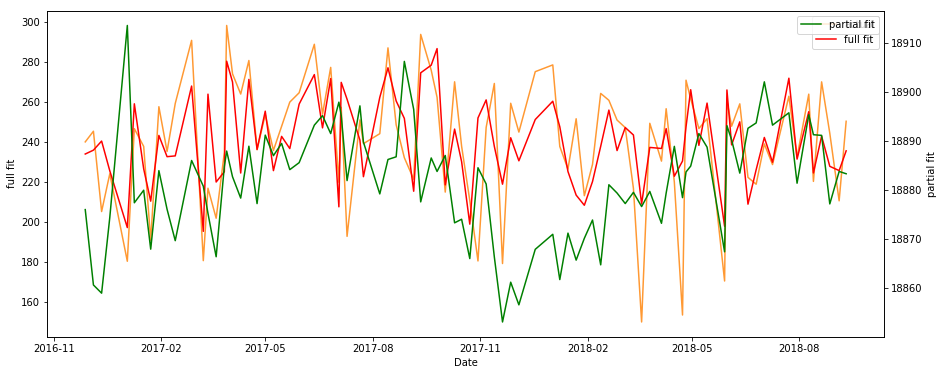

In [48]:
regress('tsnr', df)

In [14]:
# p2Xs4X35mm_BOLD.csv
files2 = pd.read_csv('../data/extractions/p2Xs4X35mm_BOLD.csv')
df2 = pd.DataFrame(files2,columns=['Date', 'tsnr', 'TxRefAmp', 'AcquisitionTime', 'SAR',
                                'RepetitionTime', 'Shim1', 'Shim2', 'Shim3', 'Shim4',
                                'Shim5', 'Shim6', 'Shim7', 'Shim8', 'IOPD1', 'IOPD2',
                                'IOPD3', 'IOPD4', 'IOPD5', 'IOPD6'])
# df2_shim = pd.DataFrame(files2,columns=['Date', 'tsnr', 'Shim1', 'Shim2', 'Shim3', 'Shim4',
#                                 'Shim5', 'Shim6', 'Shim7', 'Shim8'])
# df2_iopd = pd.DataFrame(files2,columns=['Date', 'tsnr', 'IOPD1', 'IOPD2',
#                                 'IOPD3', 'IOPD4', 'IOPD5', 'IOPD6'])
# df2_tx = pd.DataFrame(files2,columns=['Date', 'tsnr', 'TxRefAmp'])
# df2_AT = pd.DataFrame(files2,columns=['Date', 'tsnr', 'AcquisitionTime'])
# df2_SAR = pd.DataFrame(files2,columns=['Date', 'tsnr', 'SAR'])
# df2_RT = pd.DataFrame(files2,columns=['Date', 'tsnr', 'RepetitionTime'])

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


Statistically significant parameters: ['Shim5', 'Shim6']
                            OLS Regression Results                            
Dep. Variable:                   tsnr   R-squared:                       0.578
Model:                            OLS   Adj. R-squared:                  0.448
Method:                 Least Squares   F-statistic:                     4.440
Date:                Mon, 29 Apr 2019   Prob (F-statistic):           1.45e-06
Time:                        12:47:04   Log-Likelihood:                -383.11
No. Observations:                  90   AIC:                             810.2
Df Residuals:                      68   BIC:                             865.2
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

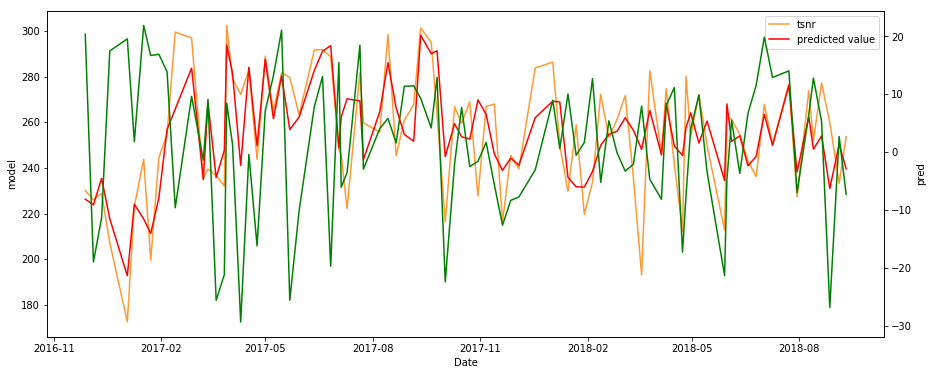

In [18]:
regress('tsnr', df2)

In [19]:
files3 = pd.read_csv('../data/extractions/anat.csv')
df3 = pd.DataFrame(files3,columns=['Date', 'snr_total', 'TxRefAmp', 'AcquisitionTime', 'SAR',
                                'RepetitionTime', 'Shim1', 'Shim2', 'Shim3', 'Shim4',
                                'Shim5', 'Shim6', 'Shim7', 'Shim8', 'IOPD1', 'IOPD2', 'IOPD3', 'IOPD4',
                                'IOPD5', 'IOPD6'])
# df3_shim = pd.DataFrame(files3,columns=['Date', 'snr_total', 'Shim1', 'Shim2', 'Shim3', 'Shim4',
#                                 'Shim5', 'Shim6', 'Shim7', 'Shim8'])
# df3_iopd = pd.DataFrame(files3,columns=['Date', 'snr_total', 'IOPD1', 'IOPD2',
#                                 'IOPD3', 'IOPD4', 'IOPD5', 'IOPD6'])
# df3_tx = pd.DataFrame(files3,columns=['Date', 'snr_total', 'TxRefAmp'])
# df3_AT = pd.DataFrame(files3,columns=['Date', 'snr_total', 'AcquisitionTime'])
# df3_SAR = pd.DataFrame(files3,columns=['Date', 'snr_total', 'SAR'])
# df3_RT = pd.DataFrame(files3,columns=['Date', 'snr_total', 'RepetitionTime'])

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


Statistically significant parameters: ['AcquisitionTime', 'SAR']
                            OLS Regression Results                            
Dep. Variable:              snr_total   R-squared:                       0.553
Model:                            OLS   Adj. R-squared:                  0.380
Method:                 Least Squares   F-statistic:                     3.194
Date:                Mon, 29 Apr 2019   Prob (F-statistic):            0.00455
Time:                        12:47:31   Log-Likelihood:                -86.977
No. Observations:                  44   AIC:                             200.0
Df Residuals:                      31   BIC:                             223.1
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

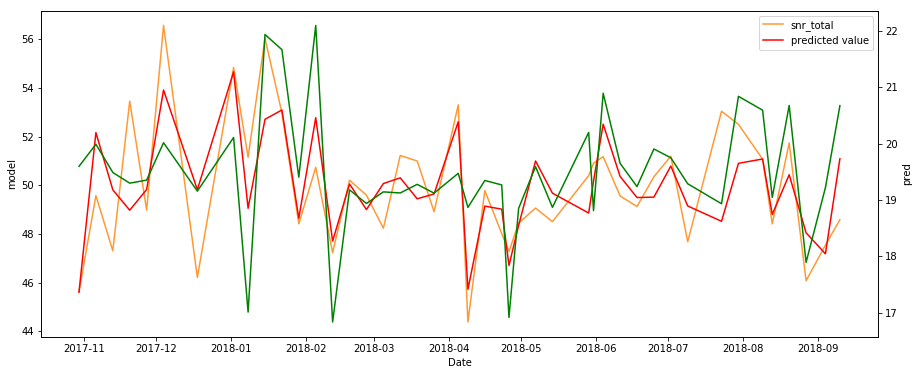

In [20]:
regress('snr_total', df3)